


# Projekt MIO

[![forthebadge](https://forthebadge.com/images/badges/60-percent-of-the-time-works-every-time.svg)](https://forthebadge.com)
[![forthebadge](https://forthebadge.com/images/badges/powered-by-black-magic.svg)](https://forthebadge.com)

Jakub Kawka, Jakub Mikusek, Jan Kapusta

In [1]:
import matplotlib.pyplot as plt
import os
import warnings
import multiprocessing as mp
import regressionModel as rm
import numpy as np 
import word2vec as w2v
import pandas as pd
import warnings
import datetime
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
# tf.debugging.set_log_device_placement(False)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-17 14:32:11.957852: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 14:32:12.138246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:32:12.897247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1
Num GPUs Available:  0
2.16.1
Num GPUs Available:  0


2024-06-17 14:32:13.509732: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 14:32:13.510211: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
def LoadDataset(size, vec_size, bounds = [0,100,1000,10000,100000]):

	filename = "realestdonaldestrumpest.csv"
 
	trumpTweets_DF = pd.read_csv(filename, sep=",")
	trumpTweets_DF = trumpTweets_DF.dropna(subset=["content"], axis=0)
 
	

	print("CSV: ",filename)

	result_data = w2v.Word2Vec()
	result_data.loadFromFile("./models_v3/calculated_model_" + str(size) + "_" + str(vec_size) + ".txt")
	result = result_data.words_df
	filtered_df = rm.FilterDataset(trumpTweets_DF, size)
	filtered_df_bak = filtered_df.copy()


	dictionary = pd.DataFrame(index=result.word.values, data=result.vector.values)

	list_of_tweets = w2v.stripPunctuation(filtered_df.content[:size])

	filtered_df["content_vectors"] = [np.vstack(result.loc[result.word.isin(tweet)].vector.values) for tweet in list_of_tweets]
	longest_tweet = 0
	for tweet in filtered_df["content_vectors"] :
		if tweet.shape[0] > longest_tweet :
			longest_tweet = tweet.shape[0]
	for i, tweet in zip(filtered_df.index, filtered_df["content_vectors"]) :
		filtered_df["content_vectors"][i] = np.pad(tweet, [(0, longest_tweet - tweet.shape[0]), (0,0)])
	input_mtx = np.stack(filtered_df["content_vectors"])
	
	# groups = [0,1,2,3,4]
	groups = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
	input_y = filtered_df.retweets.values
	# input_y = np.log(input_y)
	
	y_bounds = [input_y.min(),input_y.max()]
	# print(y_bounds)
	groups_y = []
	for y in input_y:
		if y >= y_bounds[0] and y < bounds[1]:
			groups_y.append(groups[0])
		elif y >= bounds[1] and y < bounds[2]:
			groups_y.append(groups[1])
		elif y >= bounds[2] and y < bounds[3]:
			groups_y.append(groups[2])
		elif y >= bounds[3] and y < bounds[4]:
			groups_y.append(groups[3])
		else :
			groups_y.append(groups[-1])
	
	groups_y = np.array(groups_y)
	# print(np.bincount(groups_y))
	# print(groups_y)
	# input_y = np.c_[input_y, filtered_df.favorites.values]
	# input_y = input_y.mean(axis=1)
	# print(input_y.shape)
	
	flat_X = input_mtx.mean(axis=1)
	flat_X = np.c_[flat_X, np.array([tweet.shape[0] / longest_tweet for tweet in list_of_tweets])]
	timestamp = []
	datetime_frame = [np.inf, -np.inf]
	for date in filtered_df.date.values :
		timestamp.append(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()))
		if timestamp[-1] < datetime_frame[0]:
			datetime_frame[0] = timestamp[-1]
		elif timestamp[-1] > datetime_frame[1]:
			datetime_frame[1] = timestamp[-1]

	flat_X = np.c_[flat_X, np.array([(date - datetime_frame[0]) / datetime_frame[1] for date in timestamp])]
	flat_X = np.c_[flat_X, filtered_df.haslink.values]
 
	from sklearn.preprocessing import StandardScaler
	scaler = StandardScaler()
	scaler.fit(flat_X)
	flat_X = scaler.transform(flat_X)
	
	%reset_selective -f input_mtx
	%reset_selective -f input_y
	%reset_selective -f filtered_df
	%reset_selective -f trumpTweets_DF

	return flat_X, groups_y, dictionary, filtered_df_bak

In [14]:


def calculateModel(input_mtx, input_y, X_train, y_train):
	tf.keras.utils.set_random_seed(0)
   
	retweets_model = keras.Sequential()
	retweets_model.add(keras.Input(shape=input_mtx.shape[1:]))
	retweets_model.add(keras.layers.Dense(128, activation="relu"))
	retweets_model.add(keras.layers.Dense(64, activation="relu"))
	retweets_model.add(keras.layers.Dense(32, activation="relu"))
	retweets_model.add(keras.layers.Dense(input_y.shape[1], activation="sigmoid"))
 
 
	
 
	retweets_model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(learning_rate=0.0001), metrics=[keras.metrics.CategoricalAccuracy()])

	retweets_model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=4000, shuffle=True)
 
	# y_pred_train = retweets_model.predict(input_mtx[train_split], verbose=0)
	# y_pred_test = retweets_model.predict(input_mtx[test_split], verbose=0)
 
	return retweets_model #y_pred_train, y_pred_test, history, 

In [4]:
def score(y_true, y_pred) :
	sum_squares_residuals = np.array((((y_true - y_pred) * 1e+3) ** 2), dtype=np.int64).sum(axis=0)
	sum_squares = np.array((((y_true - np.array(y_true * 1e+6, dtype = np.int64).sum(axis=0) * 1e-6 / y_true.shape[0]) * 1e+3) ** 2), dtype=np.int64).sum(axis=0)
	R2 = 1 - sum_squares_residuals / sum_squares
	return np.round(R2 * 100, 2)

In [ ]:
predictor_model = keras.models.load_model("./net/classifier.keras")

In [41]:
import sklearn

X, Y, dictionary, raw = LoadDataset(43000, 100)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y) # Stratify saves lives!


CSV:  realestdonaldestrumpest.csv


In [16]:
predictor_model = calculateModel(X, Y, X_train, y_train)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.3474 - loss: 1.7061 - val_categorical_accuracy: 0.3788 - val_loss: 1.6457
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - categorical_accuracy: 0.3735 - loss: 1.6319 - val_categorical_accuracy: 0.3895 - val_loss: 1.5750
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.3865 - loss: 1.5641 - val_categorical_accuracy: 0.4087 - val_loss: 1.5102
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4112 - loss: 1.5021 - val_categorical_accuracy: 0.4418 - val_loss: 1.4508
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4461 - loss: 1.4457 - val_categorical_accuracy: 0.4746 - val_loss: 1.3977
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.4754 - loss: 1.3955 - val_categorical_accuracy: 0.4940 - val_loss: 1.3514
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.4921 - loss: 1.3515 - val_cate

In [28]:
print("Evaluate on test data")
results = predictor_model.evaluate(X_test, y_test, batch_size=128)
print("CCE:", results)

Evaluate on test data
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - categorical_accuracy: 0.7536 - loss: 0.6098
CCE: [0.5951504111289978, 0.7597622275352478]


In [68]:
import shap

# Wrapper dla SHAP
def f(X):
    return predictor_model.predict(X)

explainer = shap.KernelExplainer(f, shap.kmeans(X, 100))

_, x_analyze, _, y_analyze, _, ind_analyze = sklearn.model_selection.train_test_split(X, Y, raw.index.values, test_size = 0.005, random_state = 42, stratify = Y) # We need a representative sample to analyze


print(ind_analyze)

explanation = explainer(x_analyze)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
[ 4422 33639  4531 34906 36725 31825  6812  5650 33511 40035  6254 10546
  5797  6218  8725 21364 31428 42123  3149 25904 41350 39221 36631 37515
  5316  8817 22361 39516  2472 30004 30034 22469 38994 15132 29137 11082
 17118 11624 21252 17322    28 22076 42485  6203 29564 39077 29860 38975
 11383 34575 29321 15384 24202 32616 28129 25652 13127 22968 21043  6074
  2979 20630  4974 18348 14763 26361 23033 20786 40908 14241 23658  9051
  5295 34114 11508 19707 20306   424 19092 21135 31452 21883 23597  4783
 14590 41244  3998 16533  5809 25216 33652  7902 20297 11565  2656  7883
 32812 33943  4988  7220 34043  6925 11293 28949 29984   625  1219 15055
  9588  2171 41474 15418 31839 41497 31444 10611 17169 41863 17074 20515
 14210 29650 38932 18938 37176 35410 40514  7005 36925  4359 42698 25279
 19471 34024 29351 25020 32213 42058 24430 42867  7041 42032 40464 10271
 21805 19411 25866  7238 30845  3087  7768 39272 42563 32145 34958 29462
 19326 18503

  0%|          | 0/215 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step


  0%|          | 1/215 [00:06<22:12,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


  1%|          | 2/215 [00:12<21:40,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


  1%|▏         | 3/215 [00:18<21:18,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


  2%|▏         | 4/215 [00:24<21:18,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


  2%|▏         | 5/215 [00:30<21:01,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step


  3%|▎         | 6/215 [00:35<20:25,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 399us/step


  3%|▎         | 7/215 [00:41<20:31,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


  4%|▎         | 8/215 [00:47<20:26,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


  4%|▍         | 9/215 [00:53<20:33,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 414us/step


  5%|▍         | 10/215 [00:59<20:26,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


  5%|▌         | 11/215 [01:05<20:02,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 417us/step


  6%|▌         | 12/215 [01:11<20:24,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


  6%|▌         | 13/215 [01:18<20:23,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


  7%|▋         | 14/215 [01:24<20:27,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


  7%|▋         | 15/215 [01:30<20:18,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


  7%|▋         | 16/215 [01:36<20:22,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


  8%|▊         | 17/215 [01:42<19:56,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 363us/step


  8%|▊         | 18/215 [01:48<19:39,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 366us/step


  9%|▉         | 19/215 [01:53<19:07,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


  9%|▉         | 20/215 [01:59<19:05,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 10%|▉         | 21/215 [02:05<18:57,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step


 10%|█         | 22/215 [02:11<18:57,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step


 11%|█         | 23/215 [02:17<18:43,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step


 11%|█         | 24/215 [02:23<18:32,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step


 12%|█▏        | 25/215 [02:28<18:21,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 373us/step


 12%|█▏        | 26/215 [02:34<17:49,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step


 13%|█▎        | 27/215 [02:39<17:57,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


 13%|█▎        | 28/215 [02:46<18:09,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 13%|█▎        | 29/215 [02:51<17:56,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 14%|█▍        | 30/215 [02:58<18:55,  6.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


 14%|█▍        | 31/215 [03:04<18:24,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 15%|█▍        | 32/215 [03:10<18:21,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step


 15%|█▌        | 33/215 [03:16<18:29,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step


 16%|█▌        | 34/215 [03:22<18:01,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 360us/step


 16%|█▋        | 35/215 [03:27<17:21,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 378us/step


 17%|█▋        | 36/215 [03:33<17:14,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step


 17%|█▋        | 37/215 [03:39<16:59,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step


 18%|█▊        | 38/215 [03:44<16:33,  5.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step


 18%|█▊        | 39/215 [03:50<16:35,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 400us/step


 19%|█▊        | 40/215 [03:55<16:33,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 362us/step


 19%|█▉        | 41/215 [04:01<16:21,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 362us/step


 20%|█▉        | 42/215 [04:06<16:06,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step


 20%|██        | 43/215 [04:12<15:52,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step


 20%|██        | 44/215 [04:18<16:02,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 373us/step


 21%|██        | 45/215 [04:23<15:49,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 369us/step


 21%|██▏       | 46/215 [04:29<15:36,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


 22%|██▏       | 47/215 [04:34<15:37,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 376us/step


 22%|██▏       | 48/215 [04:40<15:40,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 378us/step


 23%|██▎       | 49/215 [04:46<15:26,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


 23%|██▎       | 50/215 [04:52<16:01,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 24%|██▎       | 51/215 [04:58<16:11,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 24%|██▍       | 52/215 [05:04<16:28,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 405us/step


 25%|██▍       | 53/215 [05:10<16:07,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


 25%|██▌       | 54/215 [05:16<15:41,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


 26%|██▌       | 55/215 [05:21<15:19,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 26%|██▌       | 56/215 [05:27<15:17,  5.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


 27%|██▋       | 57/215 [05:33<15:11,  5.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 408us/step


 27%|██▋       | 58/215 [05:39<15:09,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step


 27%|██▋       | 59/215 [05:44<14:59,  5.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 400us/step


 28%|██▊       | 60/215 [05:50<15:02,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


 28%|██▊       | 61/215 [05:56<14:59,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 29%|██▉       | 62/215 [06:02<15:01,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


 29%|██▉       | 63/215 [06:08<14:53,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


 30%|██▉       | 64/215 [06:14<15:01,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 418us/step


 30%|███       | 65/215 [06:21<15:09,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 31%|███       | 66/215 [06:26<14:53,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 31%|███       | 67/215 [06:32<14:40,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 32%|███▏      | 68/215 [06:38<14:31,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 32%|███▏      | 69/215 [06:44<14:19,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 33%|███▎      | 70/215 [06:50<14:12,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 33%|███▎      | 71/215 [06:55<13:55,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step


 33%|███▎      | 72/215 [07:01<13:50,  5.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 34%|███▍      | 73/215 [07:07<13:43,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 34%|███▍      | 74/215 [07:13<13:50,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 35%|███▍      | 75/215 [07:20<14:04,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 35%|███▌      | 76/215 [07:26<13:59,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 419us/step


 36%|███▌      | 77/215 [07:32<14:00,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


 36%|███▋      | 78/215 [07:38<13:55,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 480us/step


 37%|███▋      | 79/215 [07:47<15:49,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 37%|███▋      | 80/215 [07:53<15:05,  6.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 38%|███▊      | 81/215 [07:59<14:26,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 38%|███▊      | 82/215 [08:05<13:56,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


 39%|███▊      | 83/215 [08:11<13:34,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 39%|███▉      | 84/215 [08:17<13:15,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 40%|███▉      | 85/215 [08:22<13:04,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 40%|████      | 86/215 [08:28<12:51,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 40%|████      | 87/215 [08:35<13:30,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 446us/step


 41%|████      | 88/215 [08:43<14:26,  6.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


 41%|████▏     | 89/215 [08:49<13:40,  6.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 42%|████▏     | 90/215 [08:55<13:06,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 42%|████▏     | 91/215 [09:02<13:10,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step


 43%|████▎     | 92/215 [09:09<13:56,  6.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 406us/step


 43%|████▎     | 93/215 [09:16<13:34,  6.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 410us/step


 44%|████▎     | 94/215 [09:23<13:59,  6.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 417us/step


 44%|████▍     | 95/215 [09:33<15:27,  7.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step


 45%|████▍     | 96/215 [09:39<14:34,  7.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 409us/step


 45%|████▌     | 97/215 [09:45<13:44,  6.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 456us/step


 46%|████▌     | 98/215 [09:52<13:16,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step


 46%|████▌     | 99/215 [09:58<12:30,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


 47%|████▋     | 100/215 [10:03<11:56,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


 47%|████▋     | 101/215 [10:09<11:32,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


 47%|████▋     | 102/215 [10:15<11:31,  6.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 48%|████▊     | 103/215 [10:21<11:14,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


 48%|████▊     | 104/215 [10:26<10:52,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 49%|████▉     | 105/215 [10:32<10:30,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 487us/step


 49%|████▉     | 106/215 [10:40<11:42,  6.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 454us/step


 50%|████▉     | 107/215 [10:48<12:31,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 433us/step


 50%|█████     | 108/215 [10:56<12:50,  7.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 416us/step


 51%|█████     | 109/215 [11:02<11:58,  6.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 51%|█████     | 110/215 [11:07<11:08,  6.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 52%|█████▏    | 111/215 [11:13<10:42,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 52%|█████▏    | 112/215 [11:19<10:27,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 53%|█████▎    | 113/215 [11:26<11:04,  6.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 53%|█████▎    | 114/215 [11:32<10:35,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 53%|█████▎    | 115/215 [11:38<10:17,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 54%|█████▍    | 116/215 [11:44<09:58,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 54%|█████▍    | 117/215 [11:49<09:41,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step


 55%|█████▍    | 118/215 [11:55<09:34,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 55%|█████▌    | 119/215 [12:01<09:23,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 56%|█████▌    | 120/215 [12:07<09:15,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 56%|█████▋    | 121/215 [12:13<09:08,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 57%|█████▋    | 122/215 [12:18<09:02,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 57%|█████▋    | 123/215 [12:24<08:53,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 58%|█████▊    | 124/215 [12:30<08:48,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 58%|█████▊    | 125/215 [12:36<08:43,  5.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 59%|█████▊    | 126/215 [12:42<08:35,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 59%|█████▉    | 127/215 [12:47<08:30,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 60%|█████▉    | 128/215 [12:53<08:23,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 60%|██████    | 129/215 [12:59<08:18,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 60%|██████    | 130/215 [13:07<09:14,  6.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 404us/step


 61%|██████    | 131/215 [13:13<08:51,  6.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


 61%|██████▏   | 132/215 [13:19<08:30,  6.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 62%|██████▏   | 133/215 [13:25<08:21,  6.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


 62%|██████▏   | 134/215 [13:31<08:09,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 63%|██████▎   | 135/215 [13:37<08:19,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 404us/step


 63%|██████▎   | 136/215 [13:44<08:16,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step


 64%|██████▎   | 137/215 [13:50<08:06,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 404us/step


 64%|██████▍   | 138/215 [13:56<07:54,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 65%|██████▍   | 139/215 [14:02<07:49,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 406us/step


 65%|██████▌   | 140/215 [14:09<07:51,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 435us/step


 66%|██████▌   | 141/215 [14:16<08:12,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step


 66%|██████▌   | 142/215 [14:22<07:44,  6.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step


 67%|██████▋   | 143/215 [14:28<07:24,  6.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 376us/step


 67%|██████▋   | 144/215 [14:33<07:06,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 379us/step


 67%|██████▋   | 145/215 [14:39<06:52,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 375us/step


 68%|██████▊   | 146/215 [14:44<06:41,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 375us/step


 68%|██████▊   | 147/215 [14:50<06:32,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 378us/step


 69%|██████▉   | 148/215 [14:56<06:24,  5.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


 69%|██████▉   | 149/215 [15:01<06:16,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step


 70%|██████▉   | 150/215 [15:07<06:10,  5.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 70%|███████   | 151/215 [15:13<06:09,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


 71%|███████   | 152/215 [15:20<06:23,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step


 71%|███████   | 153/215 [15:26<06:17,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 72%|███████▏  | 154/215 [15:32<06:11,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 442us/step


 72%|███████▏  | 155/215 [15:40<06:39,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 428us/step


 73%|███████▎  | 156/215 [15:47<06:47,  6.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step


 73%|███████▎  | 157/215 [15:56<07:02,  7.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 432us/step


 73%|███████▎  | 158/215 [16:03<06:53,  7.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 427us/step


 74%|███████▍  | 159/215 [16:09<06:35,  7.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 74%|███████▍  | 160/215 [16:16<06:21,  6.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 420us/step


 75%|███████▍  | 161/215 [16:23<06:06,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 75%|███████▌  | 162/215 [16:31<06:20,  7.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 76%|███████▌  | 163/215 [16:39<06:37,  7.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 76%|███████▋  | 164/215 [16:45<06:04,  7.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 77%|███████▋  | 165/215 [16:51<05:36,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 77%|███████▋  | 166/215 [16:57<05:15,  6.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 78%|███████▊  | 167/215 [17:03<05:00,  6.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 78%|███████▊  | 168/215 [17:08<04:47,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 79%|███████▊  | 169/215 [17:14<04:35,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 388us/step


 79%|███████▉  | 170/215 [17:20<04:28,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


 80%|███████▉  | 171/215 [17:26<04:21,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 402us/step


 80%|████████  | 172/215 [17:32<04:15,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 80%|████████  | 173/215 [17:38<04:07,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 81%|████████  | 174/215 [17:44<04:00,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 81%|████████▏ | 175/215 [17:49<03:54,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 430us/step


 82%|████████▏ | 176/215 [17:56<03:57,  6.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 438us/step


 82%|████████▏ | 177/215 [18:02<03:53,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 83%|████████▎ | 178/215 [18:08<03:42,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 377us/step


 83%|████████▎ | 179/215 [18:14<03:32,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


 84%|████████▎ | 180/215 [18:19<03:24,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


 84%|████████▍ | 181/215 [18:25<03:17,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 447us/step


 85%|████████▍ | 182/215 [18:31<03:15,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 85%|████████▌ | 183/215 [18:37<03:08,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step


 86%|████████▌ | 184/215 [18:43<03:02,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 392us/step


 86%|████████▌ | 185/215 [18:49<02:55,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 87%|████████▋ | 186/215 [18:55<02:49,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 391us/step


 87%|████████▋ | 187/215 [19:00<02:43,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 393us/step


 87%|████████▋ | 188/215 [19:06<02:37,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 88%|████████▊ | 189/215 [19:12<02:32,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 398us/step


 88%|████████▊ | 190/215 [19:18<02:26,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


 89%|████████▉ | 191/215 [19:24<02:20,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 89%|████████▉ | 192/215 [19:30<02:14,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


 90%|████████▉ | 193/215 [19:35<02:08,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 90%|█████████ | 194/215 [19:41<02:02,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 91%|█████████ | 195/215 [19:47<01:56,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 91%|█████████ | 196/215 [19:53<01:50,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 92%|█████████▏| 197/215 [19:59<01:46,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 92%|█████████▏| 198/215 [20:05<01:41,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 399us/step


 93%|█████████▎| 199/215 [20:11<01:35,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 387us/step


 93%|█████████▎| 200/215 [20:17<01:28,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


 93%|█████████▎| 201/215 [20:23<01:21,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step


 94%|█████████▍| 202/215 [20:28<01:15,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 373us/step


 94%|█████████▍| 203/215 [20:34<01:08,  5.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 397us/step


 95%|█████████▍| 204/215 [20:40<01:04,  5.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 389us/step


 95%|█████████▌| 205/215 [20:46<00:59,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 396us/step


 96%|█████████▌| 206/215 [20:52<00:53,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step


 96%|█████████▋| 207/215 [20:58<00:47,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 395us/step


 97%|█████████▋| 208/215 [21:04<00:41,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 412us/step


 97%|█████████▋| 209/215 [21:10<00:36,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 386us/step


 98%|█████████▊| 210/215 [21:16<00:29,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 394us/step


 98%|█████████▊| 211/215 [21:22<00:24,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 410us/step


 99%|█████████▊| 212/215 [21:28<00:18,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 411us/step


 99%|█████████▉| 213/215 [21:35<00:12,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step


100%|█████████▉| 214/215 [21:40<00:05,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7044/7044 ━━━━━━━━━━━━━━━━━━━━ 3s 380us/step


100%|██████████| 215/215 [21:46<00:00,  6.08s/it]


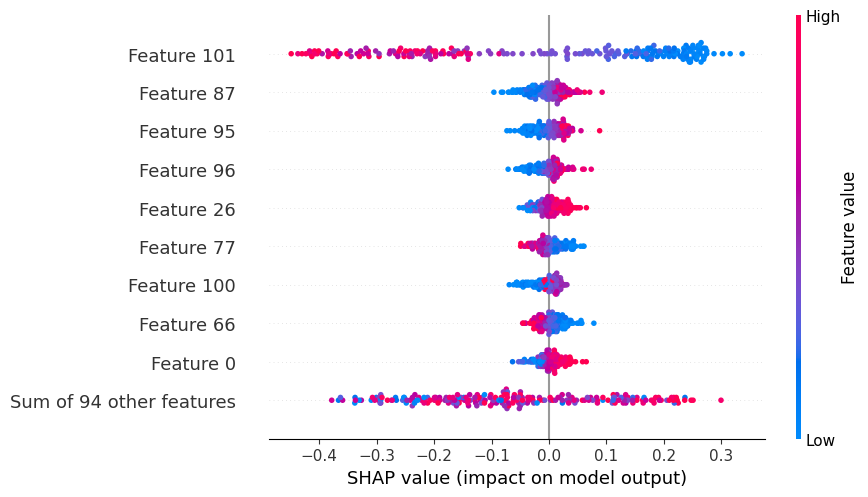

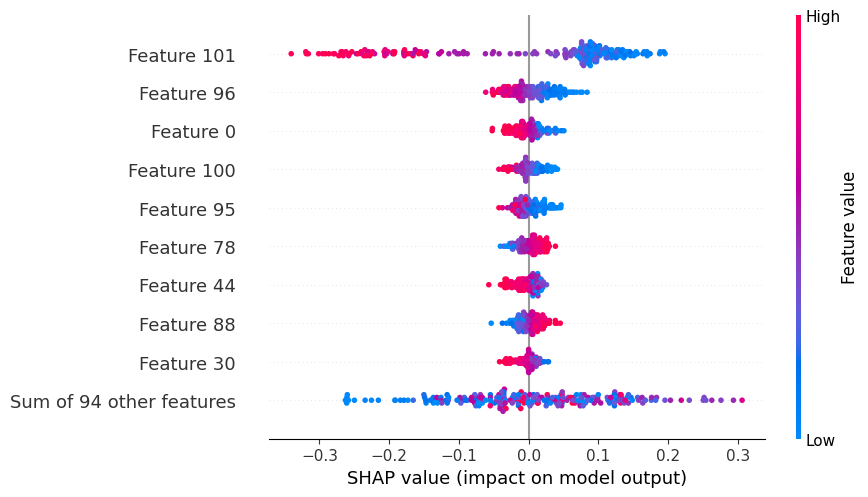

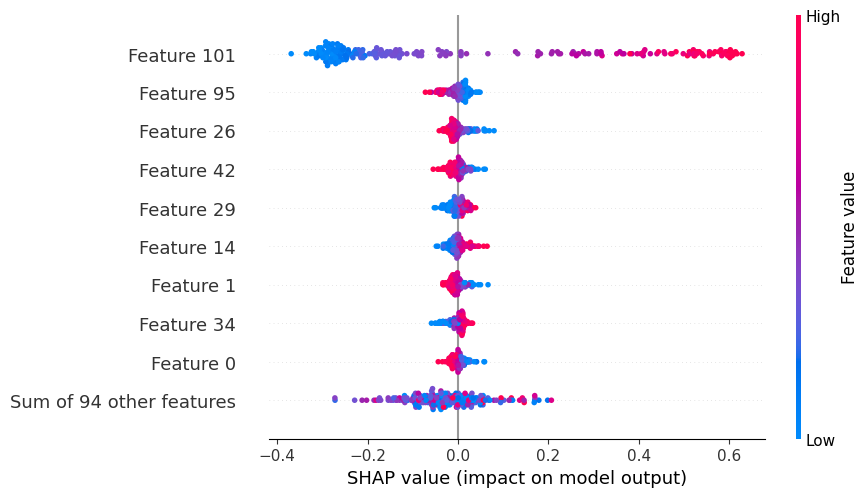

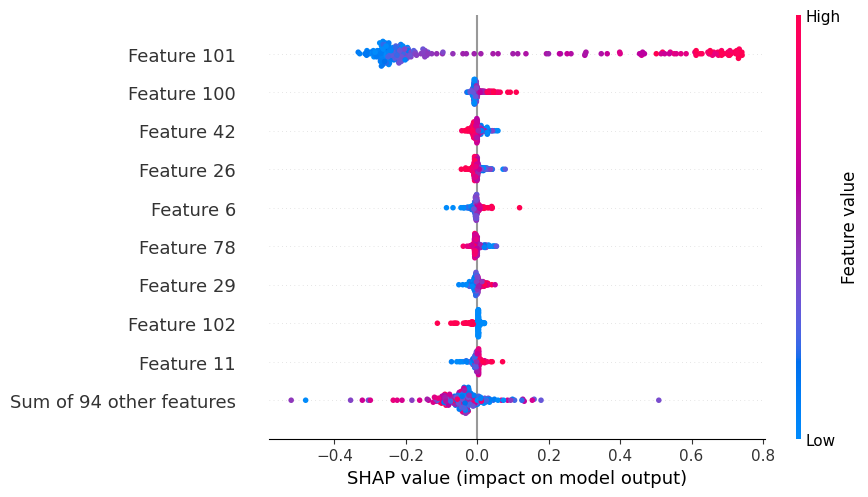

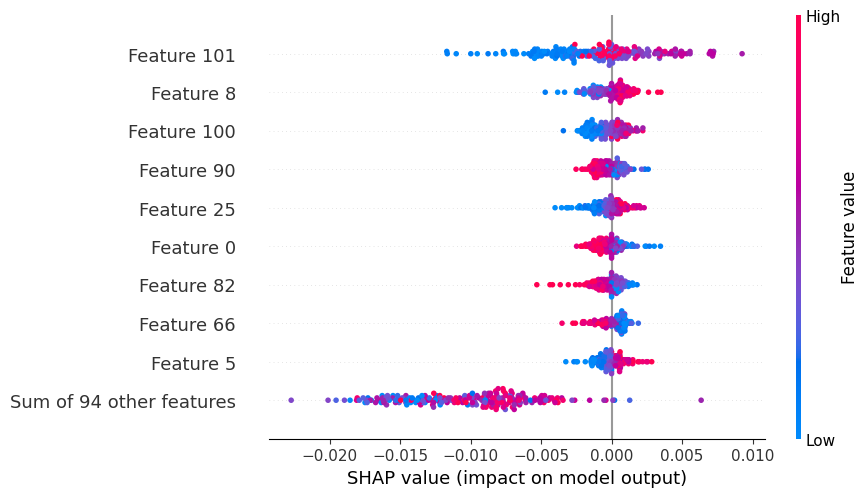

In [70]:
shap.initjs()

for i in range(0,5):
    shap.plots.beeswarm(explanation[:,:,i])
    plt.show()

(215, 103, 5)
(215,)


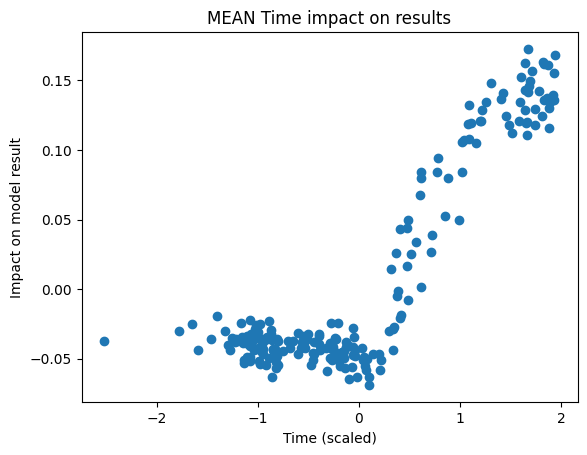

In [71]:
print(explanation.values.shape)

mean_time_impact = np.mean(explanation.values[:,101,:], axis=1)
print(mean_time_impact.shape)

plt.title("MEAN Time impact on results")
plt.xlabel("Time (scaled)")
plt.ylabel("Impact on model result")
plt.scatter(x_analyze[:, 101], mean_time_impact)
plt.show()

In [72]:
# We need to rank each feature by its usefulness globally

from scipy.stats import rankdata

global_shap_weights = []

for i in range(0,5):
    stdev = np.std(explanation.values[:,0:100,i], axis=0)
    global_shap_weights.append(10 / (rankdata(stdev) + 10))




In [74]:
# How far is a tweet from a weighted word meaning array?
def word_weighted_distance(tweet_idx, word, importance):
    return np.sum(np.multiply(np.square(X[tweet_idx, 0:100] - dictionary[0][word]), importance))

In [99]:

from termcolor import colored, cprint

y_pred = predictor_model.predict(X)

names = ["NEAR-ZERO", "LOW", "NOTICEABLE", "MAJOR", "VERY SIGNIFICANT"]

hits = [0,0,0,0,0]

for exidx, idx in enumerate(ind_analyze):

    tweet_text = raw["content"][idx]
    solution = np.argmax(y_pred[idx])
    real_solution = np.argmax(Y[idx])
    if solution == real_solution:
        hits[solution] += 1
        
    words = tweet_text.split()
   
    local_importance = 10 / (rankdata(np.abs(explanation.values[exidx, 0:100, solution])) + 10)

    
    distances_global = []
    distances_local = []
    
    
    for word in words:
        distances_global.append(word_weighted_distance(idx, word, global_shap_weights[solution]))
        distances_local.append(word_weighted_distance(idx, word, local_importance))
    
    word_global_ranks = rankdata(distances_global)
    word_local_ranks = rankdata(distances_local)
    print("\n", names[real_solution], " TWEET ", raw["retweets"][idx], " RANKED ", names[solution])
    
    print(raw["content"][idx])
    
    for widx, word in enumerate(words):
        attrs = []
        color = "blue"
        back = None
        
        if (word_local_ranks[widx] == 1):
            attrs.append("bold")
            color = "green"
            
        if (word_global_ranks[widx] == 1):
            color = "green"
            attrs.append("underline")
            
        if (word_local_ranks[widx] < 3 or word_global_ranks[widx] < 3):
            back = "on_black"
            
        cprint(word, color, back, attrs)

print(hits)


1341/1341 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step

 NOTICEABLE  TWEET  1210  RANKED  LOW
another four years good country live
another
four
years
good
country
live

 NOTICEABLE  TWEET  27007  RANKED  NOTICEABLE
question russian meddling took place obama administration right january aren subject investigation didn obama something meddling aren dem crimes investigation ask jeff sessions
question
russian
meddling
took
place
obama
administration
right
january
aren
subject
investigation
didn
obama
something
meddling
aren
dem
crimes
investigation
ask
jeff
sessions

 LOW  TWEET  771  RANKED  NEAR-ZERO
you best product world people dont know going worth much art deal
you
best
product
world
people
dont
know
going
worth
much
art
deal

 MAJOR  TWEET  15166  RANKED  MAJOR
thank pennsylvania donaldself love you urlstring ezt
thank
pennsylvania
donaldself
love
you
urlstring
ezt

 MAJOR  TWEET  26820  RANKED  MAJOR
approval rating republican party record pretty amazing considering also donaldself press rea